# BLIP-2 Image Captioning on Dishes

Based on [Chat_with_BLIP_2.ipynb](https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BLIP-2/Chat_with_BLIP_2.ipynb) and [Fine-tune BLIP2 on an image captioning dataset PEFT.ipynb](https://colab.research.google.com/drive/16XbIysCzgpAld7Kd9-xz-23VPWmqdWmW?usp=sharing).

## Set-up environment

In [ ]:
pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Load the test image captioning dataset

In [ ]:
from datasets import load_dataset
dataset = load_dataset("advancedcv/Food500Cap_test",split="test")

Let's retrieve the caption of the first example:

In [ ]:
dataset[0]["caption"]

'Baked thin AEbleflaesk slices with brown dried surface alternate with yellow apple slices.'

And the corresponding image

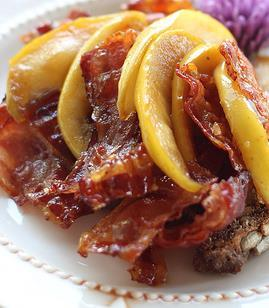

In [ ]:
dataset[0]["image"]

And the label

In [ ]:
dataset[0]["cat"]

'AEbleflaesk'

## Inference with BLIP-2 models

In [ ]:
import random
import numpy as np
import torch
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)

### Load Original and Fine-tuned Models

In [ ]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from datetime import datetime
import pytz

device = "cuda" if torch.cuda.is_available() else "cpu"
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
# by default `from_pretrained` loads the weights in float32
# we load in float16 instead to save memory
model_original = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# Helper function to clean captions
def handle_caption(caption):
  if caption.endswith('\n'):
    caption = caption[:-len('\n')]
  if caption.endswith('�'):
    caption = caption[:-len('�')]
  return caption

### Naive Captioning with Original BLIP-2

In [ ]:
model_original.to(device)
generated_texts = []
index = 0
for data in dataset:
  images = data['image']
  inputs = processor(images, return_tensors="pt").to(device, torch.float16)
  generated_ids = model_original.generate(**inputs, max_new_tokens=30)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
  generated_texts.append(handle_caption(generated_text))
  index += 1
  if index % 500 == 0:
    now = datetime.now(pytz.timezone('America/Chicago'))
    print(index, now)
print(generated_texts[0])
# Save results
np.save("BLIP2_original_naive_captioning_results.npy", generated_texts)

500 2023-11-05 12:24:55.625117-06:00
1000 2023-11-05 12:28:23.000092-06:00
1500 2023-11-05 12:31:49.934722-06:00
2000 2023-11-05 12:35:11.394939-06:00
2500 2023-11-05 12:38:37.356997-06:00
3000 2023-11-05 12:42:05.395609-06:00
3500 2023-11-05 12:45:30.746360-06:00
4000 2023-11-05 12:48:54.092673-06:00
4500 2023-11-05 12:52:16.821582-06:00
a plate topped with bacon and peaches


### Multiple Prompted Captioning with Original BLIP-2

In [ ]:
generated_texts = []
index = 0
for data in dataset:
  images = data['image']

  prompt = "the name of this dish is"
  inputs = processor(images, text=prompt, return_tensors="pt").to(device, torch.float16)
  generated_ids = model_original.generate(**inputs, max_new_tokens=10)
  generated_text1 = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

  prompt = "the visible ingredients of this dish are"
  inputs = processor(images, text=prompt, return_tensors="pt").to(device, torch.float16)
  generated_ids = model_original.generate(**inputs, max_new_tokens=20)
  generated_text2 = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

  generated_text = "a dish of " + handle_caption(generated_text1) + " with " + handle_caption(generated_text2)
  generated_texts.append(generated_text)

  index += 1
  if index % 500 == 0:
    now = datetime.now(pytz.timezone('America/Chicago'))
    print(index, now)
print(generated_texts[0])
# Save results
np.save("BLIP2_original_multiple_prompted_captioning_results.npy", generated_texts)

500 2023-11-05 13:00:00.247104-06:00
1000 2023-11-05 13:04:55.283809-06:00
1500 2023-11-05 13:09:45.749395-06:00
2000 2023-11-05 13:14:44.378244-06:00
2500 2023-11-05 13:19:39.659989-06:00
3000 2023-11-05 13:24:31.266523-06:00
3500 2023-11-05 13:29:20.923278-06:00
4000 2023-11-05 13:34:10.327590-06:00
4500 2023-11-05 13:39:01.234907-06:00
a dish of peaches and bacon with the peaches and bacon


### Visual Question Answering (VQA) with Original BLIP-2

We can create a ChatGPT-like interface by simply concatenating each generated response to the conversation. We prompt the model with some text (like "what is the name of this dish?"), the model generates an answer for it, which we just concatenate to the conversation. Then we ask a follow-up question ("what are the ingredients in this dish?") which we also just concatenate and feed to the model.

In [ ]:
generated_texts = []
index = 0
for data in dataset:
  images = data['image']

  prompt = "Question: what is the name of this dish? Answer:"
  inputs = processor(images, text=prompt, return_tensors="pt").to(device, torch.float16)
  generated_ids = model_original.generate(**inputs, max_new_tokens=10)
  generated_text1 = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
  prompt = prompt + " " + handle_caption(generated_text1) + ". Question: what are the visible ingredients in this dish? Answer:"
  inputs = processor(images, text=prompt, return_tensors="pt").to(device, torch.float16)
  generated_ids = model_original.generate(**inputs, max_new_tokens=20)
  generated_text2 = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
  generated_text = "a dish of " + handle_caption(generated_text1) + " with " + handle_caption(generated_text2)
  generated_texts.append(generated_text)

  index += 1
  if index % 500 == 0:
    now = datetime.now(pytz.timezone('America/Chicago'))
    print(index, now)
print(generated_texts[0])
# Save results
np.save("BLIP2_original_VQA_results.npy", generated_texts)

500 2023-11-05 13:48:59.409642-06:00
1000 2023-11-05 13:54:52.827973-06:00
1500 2023-11-05 14:00:35.303949-06:00
2000 2023-11-05 14:06:10.219619-06:00
2500 2023-11-05 14:11:50.494705-06:00
3000 2023-11-05 14:17:33.422238-06:00
3500 2023-11-05 14:23:20.642620-06:00
4000 2023-11-05 14:28:58.749855-06:00
4500 2023-11-05 14:34:50.240688-06:00
a dish of bacon peach cobbler with bacon, peaches, and a little bit of sugar


In [ ]:
# Free GPU memory
del model_original
torch.cuda.empty_cache()

### Naive Captioning with BLIP-2 Fine-tuned on Entire Fine-tuning Set

In [ ]:
from peft import PeftModel
model_finetuned_all = Blip2ForConditionalGeneration.from_pretrained("advancedcv/blip2-opt-2.7b_Food500Cap_finetuned", torch_dtype=torch.float16)
model_finetuned_sub = Blip2ForConditionalGeneration.from_pretrained("advancedcv/blip2-opt-2.7b_Food500Cap_finetuned_subset", torch_dtype=torch.float16)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model_finetuned_all.to(device)
generated_texts = []
index = 0
for data in dataset:
  images = data['image']
  inputs = processor(images, return_tensors="pt").to(device, torch.float16)
  generated_ids = model_finetuned_all.generate(**inputs, max_new_tokens=30)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
  generated_texts.append(handle_caption(generated_text))

  index += 1
  if index % 500 == 0:
    now = datetime.now(pytz.timezone('America/Chicago'))
    print(index, now)
print(generated_texts[0])
# Save results
np.save("BLIP2_finetuned_all_naive_captioning_results.npy", generated_texts)

500 2023-11-05 16:53:41.096757-06:00
1000 2023-11-05 17:10:16.096569-06:00
1500 2023-11-05 17:26:54.577648-06:00
2000 2023-11-05 17:43:32.016012-06:00
2500 2023-11-05 18:00:13.455811-06:00
3000 2023-11-05 18:16:53.416653-06:00
3500 2023-11-05 18:33:33.924061-06:00
4000 2023-11-05 18:50:10.816217-06:00
4500 2023-11-05 19:06:52.269723-06:00
A plate of AEbleflaesk with many slices of pork belly and apple slices, with a flower and a few grains of salt on the


In [ ]:
# Free GPU memory
del model_finetuned_all
torch.cuda.empty_cache()

### Naive Captioning with BLIP-2 Fine-tuned on Subset of Fine-tuning Set

In [ ]:
model_finetuned_sub.to(device)
generated_texts = []
index = 0
for data in dataset:
  images = data['image']
  inputs = processor(images, return_tensors="pt").to(device, torch.float16)
  generated_ids = model_finetuned_sub.generate(**inputs, max_new_tokens=30)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
  generated_texts.append(handle_caption(generated_text))
  index += 1
  if index % 500 == 0:
    now = datetime.now(pytz.timezone('America/Chicago'))
    print(index, now)
print(generated_texts[0])
# Save results
np.save("BLIP2_finetuned_sub_naive_captioning_results.npy", generated_texts)

### Naive Captioning with Zero-shot/Challenging finetuned BLIP-2

In [ ]:
model_challenging = Blip2ForConditionalGeneration.from_pretrained("advancedcv/blip2-opt-2.7b_Food500Cap_finetuned_challenging", torch_dtype=torch.float16)

In [ ]:
model_challenging.to(device)
generated_texts = []
index = 0
for data in dataset:
  images = data['image']
  inputs = processor(images, return_tensors="pt").to(device, torch.float16)
  generated_ids = model_challenging.generate(**inputs, max_new_tokens=30)
  generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
  generated_texts.append(handle_caption(generated_text))

  index += 1
  if index % 500 == 0:
    now = datetime.now(pytz.timezone('America/Chicago'))
    print(index, now)
print(generated_texts[0])
# Save results
np.save("BLIP2_finetuned_challenging_naive_captioning_results_on_test.npy", generated_texts)

In [ ]:
# Free GPU memory
del model_finetuned_sub
torch.cuda.empty_cache()